# Data Preparation

## Package Imports 

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

## Control Parameters

In [3]:
class_weight = {0:9, 1:1} #An alternative, we could use 'balanced' or 'balanced_subsample'

## Importing Data

In [4]:
all_data = pd.read_excel(r'Regression_Analysis_Sheet_(Imputation_and_All_Features_Tradewar).xlsx')

## Merging Similar Columns

In [5]:
all_data['Communications'] = all_data['Communications'] + all_data['Communication Services']
all_data.drop('Communication Services', axis=1, inplace=True)

all_data['Consumer'] = (all_data['Consumer Discretionary'] + 
                        all_data['Consumer, Cyclical'] + 
                        all_data['Consumer, Cyclical, Financial, Industrial'] +
                        all_data['Consumer, Non-cyclical'] +
                        all_data['Consumer, Non-cyclical, Industrial'])

all_data.drop(['Consumer Discretionary',
               'Consumer, Cyclical',
               'Consumer, Cyclical, Financial, Industrial',
               'Consumer, Non-cyclical',
               'Consumer, Non-cyclical, Industrial'],
                axis=1, inplace=True
             )

all_data['Industrials'] = all_data['Industrials'] + all_data['Industrial']
all_data.drop('Industrial', axis=1, inplace=True)

all_data['Technology'] = all_data['Technology'] + all_data['Information Technology']
all_data.drop('Information Technology', axis=1, inplace=True)

all_data['Financial'] = all_data['Financial'] + all_data['Financials']
all_data.drop('Financials', axis=1, inplace=True)

all_data['Materials'] = all_data['Materials'] + all_data['Material']
all_data.drop('Material', axis=1, inplace=True)

all_data['Energy and Utilities'] = all_data['Energy'] + all_data['Utilities']
all_data.drop(['Energy', 'Utilities'], axis=1, inplace=True)

## Splitting Data

In [6]:
X = all_data.drop('Outcome Variable:', axis=1)
Y = all_data['Outcome Variable:']

x_train, x_test, y_train, y_test = \
train_test_split(X, Y, test_size=0.2, stratify = Y, random_state=42)

## Scaling Data

In [7]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train, columns = X.columns)

x_test = scaler.fit_transform(x_test)
x_test = pd.DataFrame(x_test, columns = X.columns)

# Searching for Optimal Hyperparameters

In [8]:
# Defining search parameters
rfc = RandomForestClassifier(class_weight = class_weight, random_state=42)
n_estimators = \
[int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)] # number of trees in random forest

max_features = ['auto', 'sqrt'] # number of features at every split

max_depth = [int(x) for x in np.linspace(100, 500, num = 11)] # max depth
max_depth.append(None)

# Creating random grid
random_grid = {
 'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth
}

# Random search of parameters
rfc_grid = RandomizedSearchCV(estimator = rfc, 
                              param_distributions = random_grid,
                              n_iter = 100,
                              cv = 3,
                              verbose=2,
                              random_state=42,
                              n_jobs = -1)
# Fit the model
rfc_grid.fit(x_train, y_train)

# Printing results
print(rfc_grid.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': None}


# Refitting Model with Optimal Hyperparameters to Find Most Important Features

## Refitting With Optimal Hpyerparameters

In [9]:
rfc_optimal = RandomForestClassifier(n_estimators=rfc_grid.best_params_['n_estimators'],
                                     class_weight = class_weight,
                                     max_depth=rfc_grid.best_params_['max_depth'],
                                     max_features=rfc_grid.best_params_['max_features'],
                                     random_state=42)
rfc_optimal.fit(x_train,y_train)
rfc_optimal_predict = rfc_optimal.predict(x_test)
rfc_optimal_cv_score = cross_val_score(rfc_optimal,
                                       X,
                                       Y,
                                       cv=10,
                                       scoring='roc_auc')

print("=== Optimal Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_optimal_predict))
print('\n')
print("=== Optimal Classification Report ===")
print(classification_report(y_test, rfc_optimal_predict))
print('\n')
print("=== All AUC Scores for Optimal RFC ===")
print(rfc_optimal_cv_score)
print('\n')
print("=== Mean AUC Score for Optimal RFC ===")
print("Mean AUC Score - Random Forest: ", rfc_optimal_cv_score.mean())

=== Optimal Confusion Matrix ===
[[ 0  5]
 [ 1 41]]


=== Optimal Classification Report ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.89      0.98      0.93        42

    accuracy                           0.87        47
   macro avg       0.45      0.49      0.47        47
weighted avg       0.80      0.87      0.83        47



=== All AUC Scores for Optimal RFC ===
[0.73015873 0.38888889 0.49206349 0.65079365 0.88095238 0.76190476
 0.33333333 0.52380952 0.66666667 0.60833333]


=== Mean AUC Score for Optimal RFC ===
Mean AUC Score - Random Forest:  0.6036904761904762


## Printing Important Features and Selecting Top 5

In [26]:
feature_importance = pd.Series(rfc_optimal.feature_importances_,
                               index=X.columns.values).sort_values(ascending=False)
print('First-pass most important features and coefficients (truncated):\n')
print(feature_importance)

First-pass most important features and coefficients (truncated):

Value Variable:                0.226415
IPR:                           0.148622
Esp:                           0.076864
Industrials                    0.047845
Stock                          0.038019
china                          0.035679
Cash                           0.033500
Technology                     0.032931
hong kong                      0.031272
Consumer                       0.031112
Communications                 0.026936
Energy and Utilities           0.022670
Voluntary Offer Agreements     0.022617
Tradewar Variable:             0.021524
united kingdom                 0.019833
Undisclosed                    0.018782
Comprehensive safeguards       0.018471
Financial                      0.017555
canada                         0.016964
france                         0.016126
Materials                      0.014191
Basic Materials                0.011217
japan                          0.010529
luxembourg    

In [11]:
container = feature_importance[:5].axes
new_model_columns = []
for i in range(5):
    new_model_columns.append(container[0][i])
print(new_model_columns)

['Value Variable:', 'IPR:', 'Esp:', 'Industrials', 'Stock']


# Re-running Random Forest with Most Important Features

## Making New Dataset with Only Top 5 Features

In [12]:
top_features_x = all_data[new_model_columns]
print(top_features_x.head())

   Value Variable:  IPR:  Esp:  Industrials  Stock
0        91.000000  7.68   0.0            0      0
1      1688.810000  8.62   0.4            0      0
2      4146.400000  8.20   0.0            1      0
3       358.430000  7.68   0.0            0      0
4      3667.369452  7.30   0.0            1      0


## Splitting and Scaling New Data

In [13]:
x_train, x_test, y_train, y_test = train_test_split(top_features_x,
                                                    Y, test_size=0.2, 
                                                    stratify = Y, 
                                                    random_state=42)

In [14]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train, columns = top_features_x.columns)

x_test = scaler.fit_transform(x_test)
x_test = pd.DataFrame(x_test, columns = top_features_x.columns)

In [15]:
print(rfc_grid.best_params_['max_depth'])

None


## Using New Dataset to Find Optimal Hyperparameters (Focused Around Results from Earlier Random Search)

In [16]:
# Defining search parameters (searching around optimal parameters discovered in random search)
rfc = RandomForestClassifier(class_weight = class_weight, random_state=42)
n_estimators = [int(x) for x in np.linspace(start = rfc_grid.best_params_['n_estimators'] - 100, 
                                            stop = rfc_grid.best_params_['n_estimators'] + 100,
                                            num = 10)] # number of trees in random forest
max_features = ['auto'] # number of features at every split

if rfc_grid.best_params_['max_depth'] == None:
    max_depth = [rfc_grid.best_params_['max_depth']]
else:
    max_depth = [int(x) for x in np.linspace(rfc_grid.best_params_['max_depth']-20,
                                             rfc_grid.best_params_['max_depth']+20,
                                             num = 5)] # max depth
# max_depth.append(None)

# Creating search grid
search_grid = {
 'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth
}

# Grid search of parameters
rfc_grid = GridSearchCV(estimator = rfc,
                        param_grid = search_grid,
                        cv = 3,
                        verbose=2,
                        n_jobs = -1)

# Fitting the model
rfc_grid.fit(x_train, y_train)

# Printing results
print(rfc_grid.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'max_depth': None, 'max_features': 'auto', 'n_estimators': 211}


## Refitting with Optimal Hyperparameters

=== Optimal Confusion Matrix from Focused Featureset ===
[[ 0  5]
 [ 2 40]]


=== Optimal Classification Report from Focused Featureset ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.89      0.95      0.92        42

    accuracy                           0.85        47
   macro avg       0.44      0.48      0.46        47
weighted avg       0.79      0.85      0.82        47



=== All AUC Scores for Optimal RFC from Focused Featureset ===
[0.72222222 0.38095238 0.5        0.64285714 0.89285714 0.76190476
 0.35714286 0.54761905 0.65       0.60833333]


=== Mean AUC Score for Optimal RFC from Focused Featureset ===
Mean AUC Score - Random Forest:  0.6063888888888889


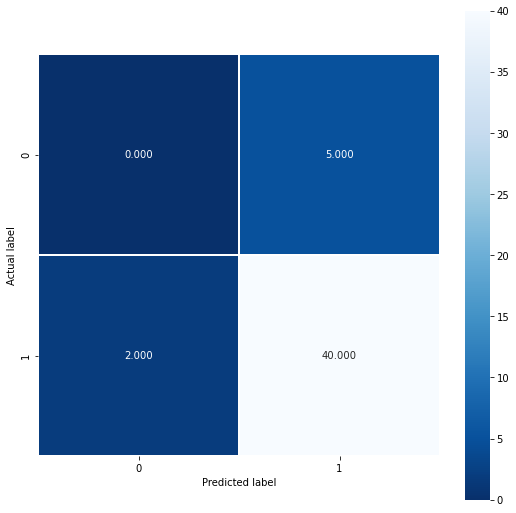

In [21]:
rfc_optimal_focused = RandomForestClassifier(n_estimators=rfc_grid.best_params_['n_estimators'],
                                     class_weight = class_weight,
                                     max_depth=rfc_grid.best_params_['max_depth'],
                                     max_features=rfc_grid.best_params_['max_features'],
                                     random_state=42)

rfc_optimal_focused.fit(x_train,y_train)
rfc_optimal_focused_predict = rfc_optimal_focused.predict(x_test)
rfc_optimal_focused_cv_score = cross_val_score(rfc_optimal_focused,
                                               X,
                                               Y, 
                                               cv=10,
                                               scoring='roc_auc')
cm = confusion_matrix(y_test, rfc_optimal_focused_predict)
print("=== Optimal Confusion Matrix from Focused Featureset ===")
print(cm)
print('\n')

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
#all_sample_title = 'Accuracy Score: {0}'.format(score)
#plt.title(all_sample_title, size = 15)

print("=== Optimal Classification Report from Focused Featureset ===")
print(classification_report(y_test, rfc_optimal_focused_predict))
print('\n')
print("=== All AUC Scores for Optimal RFC from Focused Featureset ===")
print(rfc_optimal_focused_cv_score)
print('\n')
print("=== Mean AUC Score for Optimal RFC from Focused Featureset ===")
print("Mean AUC Score - Random Forest: ", rfc_optimal_focused_cv_score.mean())

## Printing Final Most Important Features

In [27]:
final_feature_importance = pd.Series(rfc_optimal_focused.feature_importances_,
                                     index=top_features_x.columns.values).sort_values(ascending=False)
print('Final feature importance weights (after dropping other features):\n')
print(final_feature_importance)

Final feature importance weights (after dropping other features):

Value Variable:    0.410838
IPR:               0.306799
Esp:               0.148229
Stock              0.069532
Industrials        0.064603
dtype: float64


# Using Model to Predict Transaction Outcomes

## Importing Experimental Transactions

In [23]:
experimental_data = pd.read_excel(r'Experimental_Transactions_(Tradewar_Update).xlsx')
experimental_data = experimental_data[new_model_columns]

## Using Test Transactions to Get Predicted Outcome from Model

In [24]:
experimental_outcomes = rfc_optimal_focused.predict(experimental_data)

#Original Chinese Transaction (blocked in real life)
print('Original Chinese Transaction (failed in real life). Predicted outcome: ', 
      experimental_outcomes[0])

#Same transaction, but China has IPR, Esp, and Nuclear variables of Canada
print('Same transaction, but China has IPR, Esp, and Nuclear variables of Canada. Predicted outcome: ', 
      experimental_outcomes[1])

#Same transaction, but country is Canada instead of China and Canada has China's IPR, Esp, and Nuclear variables
print('Same transaction, but country is Canada instead of China and Canada has China IPR, Esp, and Nuclear variables.\
 Predicted outcome: ', 
      experimental_outcomes[2])

#Same transaction, but country is Canada and Canada has its own IPR, Esp, and Nuclear variables
print('Same transaction, but country is Canada and Canada has its own IPR, Esp, and Nuclear variables.\
 Predicted outcome: ', 
      experimental_outcomes[3])

#Same as 2, but trade war variable is 1
print('5. Same as 2., but trade war variable is active (1): ', 
      experimental_outcomes[4])

#Same as 4, but trade war variable is 1
print('6. Same as 4., but trade war variable is active (1): ', 
      experimental_outcomes[5])

#Totally fabricated transaction 1
print('7. China w/ same IPR and Esp. as used in logistic model; $750M Financial sector transcation: ', 
      experimental_outcomes[6])

#Totally fabricated transaction 2
print('8. China w/ same IPR and Esp. as used in logistic model; $400M Materials sector transcation: ', 
      experimental_outcomes[7])

#Totally fabricated transaction 3
print('China w/ same IPR and Esp. as used in logistic model; $1000M Financial sector transcation\
tradewar variable active: ', 
      experimental_outcomes[8])

Original Chinese Transaction (failed in real life). Predicted outcome:  1
Same transaction, but China has IPR, Esp, and Nuclear variables of Canada. Predicted outcome:  1
Same transaction, but country is Canada instead of China and Canada has China IPR, Esp, and Nuclear variables. Predicted outcome:  1
Same transaction, but country is Canada and Canada has its own IPR, Esp, and Nuclear variables. Predicted outcome:  1
5. Same as 2., but trade war variable is active (1):  1
6. Same as 4., but trade war variable is active (1):  1
7. China w/ same IPR and Esp. as used in logistic model; $750M Financial sector transcation:  1
8. China w/ same IPR and Esp. as used in logistic model; $400M Materials sector transcation:  1
China w/ same IPR and Esp. as used in logistic model; $1000M Financial sector transcationtradewar variable active:  1
